In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, to_hex
from matplotlib.ticker import FixedLocator
from plot_config import PlotConfig
import json
import bgp_qnm_fits as bgp

# Configuration
config = PlotConfig()


special_color_1 = to_hex("#C26C88")

DATA_TYPE = 'news'
T = 100
INCLUDE_CHIF = False
INCLUDE_MF = False

L_GROUPS = [2, 3, 4, 5, 6]
custom_cmap = LinearSegmentedColormap.from_list("custom_colormap", config.colors)
l_to_color = {
    l: custom_cmap(i / (len(L_GROUPS) - 1))
    for i, l in enumerate(L_GROUPS)
}

In [2]:
def get_fits(sim_id, mode_content_data_dict, t0_vals, full_modes_list, spherical_modes): 
    sim = bgp.SXS_CCE(sim_id, type=DATA_TYPE, lev="Lev5", radius="R2")
    tuned_param_dict_GP = bgp.get_tuned_param_dict("GP", data_type=DATA_TYPE)[sim_id]
    Mf, chif = sim.Mf, sim.chif_mag

    full_modes_list = [list(map(tuple, inner_list)) for inner_list in mode_content_data_dict["modes"]]

    fits = [] 

    #fits_full = bgp.BGP_fit(sim.times, 
    #                        sim.h, 
    #                        list(set(initial_modes + candidate_modes)), 
    #                        sim.Mf, 
    #                        sim.chif_mag, 
    #                        tuned_param_dict_GP, 
    #                        bgp.kernel_GP, 
    #                        t0=t0_vals, 
    #                        T=T, 
    #                        decay_corrected=True,
    #                        spherical_modes = spherical_modes,
    #                        include_chif=INCLUDE_CHIF,
    #                        include_Mf=INCLUDE_MF,
    #                        data_type=DATA_TYPE)

    for i, t0 in enumerate(t0_vals): 

        print(f'Fitting from {t0=}')

        select_modes = full_modes_list[i]
        fits.append(bgp.BGP_fit(sim.times, 
                                    sim.h, 
                                    select_modes, 
                                    sim.Mf, 
                                    sim.chif_mag, 
                                    tuned_param_dict_GP, 
                                    bgp.kernel_GP, 
                                    t0=t0, 
                                    T=T, 
                                    decay_corrected=True,
                                    strain_parameters=True,
                                    spherical_modes = spherical_modes,
                                    include_chif=INCLUDE_CHIF,
                                    include_Mf=INCLUDE_MF,
                                    data_type=DATA_TYPE)
                    )
    
    return fits 

In [3]:
sim_id = "0010"

with open(f'mode_content_files/mode_content_data_{sim_id}.json', 'r') as f:
    mode_content_data_dict = json.load(f)

t0_vals = np.array(mode_content_data_dict['times'])
spherical_modes = [tuple(mode) for mode in mode_content_data_dict['spherical_modes']]
initial_modes = [tuple(mode) for mode in mode_content_data_dict['initial_modes']]
candidate_modes = [tuple(mode) for mode in mode_content_data_dict['candidate_modes']]

l_max = max(mode[0] for mode in candidate_modes if len(mode) == 4)
n_max = max(mode[2] for mode in candidate_modes if len(mode) == 4)

full_modes_list = [list(map(tuple, inner_list)) for inner_list in mode_content_data_dict["modes"]]
unique_modes = list(set(mode for modes in full_modes_list for mode in modes))
fits = get_fits(sim_id, mode_content_data_dict, t0_vals, full_modes_list, spherical_modes)

/data/vault/rvnd2/Code/qnmfits/qnmfits/Waveforms/Base.py:116: RuntimeWarning: divide by zero encountered in divide
  chidot = self.Jdot/(self.Moft**2).reshape(len(self.Moft),1)


Fitting from t0=0.0
Fitting from t0=2.0
Fitting from t0=4.0
Fitting from t0=6.0
Fitting from t0=8.0
Fitting from t0=10.0
Fitting from t0=12.0
Fitting from t0=14.0
Fitting from t0=16.0
Fitting from t0=18.0
Fitting from t0=20.0
Fitting from t0=22.0
Fitting from t0=24.0
Fitting from t0=26.0
Fitting from t0=28.0
Fitting from t0=30.0
Fitting from t0=32.0
Fitting from t0=34.0
Fitting from t0=36.0
Fitting from t0=38.0
Fitting from t0=40.0
Fitting from t0=42.0
Fitting from t0=44.0
Fitting from t0=46.0
Fitting from t0=48.0
Fitting from t0=50.0
Fitting from t0=52.0
Fitting from t0=54.0
Fitting from t0=56.0
Fitting from t0=58.0
Fitting from t0=60.0


In [4]:
def masks(mode, t0_vals, full_modes_list):
    mask = np.array([mode in full_modes_list[i] for i in range(len(t0_vals))])
    segments = []
    i = 0
    while i < len(mask):
        if mask[i]:
            start = i
            while i + 1 < len(mask) and mask[i + 1]:
                i += 1
            end = i + 1
            segments.append(np.arange(start, end))
        i += 1
    return segments

In [5]:
masks((2,2,0,1,4,4,0,1), t0_vals, full_modes_list)

[array([0, 1, 2, 3, 4, 5]),
 array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]),
 array([25])]

In [6]:
nonlinear_modes = {
    (2,2,0,1,2,2,0,1): r'$(2,2,0,+)^2$',
    (2,2,0,1,3,3,0,1): r'$(2,2,0,+) \times (3,3,0,+)$',
    (3,3,0,1,3,3,0,1): r'$(3,3,0,+)^2$',
    (2,2,0,1,4,4,0,1): r'$(2,2,0,+) \times (4,4,0,+)$',
    (2,2,0,1,2,2,0,1,2,2,0,1): r'$(2,2,0,+)^3$',
    (2,-2,0,-1,2,-2,0,-1): r'$(2,-2,0,-)^2$',
    (2,-2,0,-1,3,-3,0,-1): r'$(2,-2,0,-) \times (3,-3,0,-)$',
    (3,-3,0,-1,3,-3,0,-1): r'$(3,-3,0,-)^2$',
    (2,-2,0,-1,4,-4,0,-1): r'$(2,-2,0,-) \times (4,-4,0,-)$',
    (2,-2,0,-1,2,-2,0,-1,2,-2,0,-1): r'$(2,-2,0,-)^3$'
}

nonlinear_linestyle = {
            (2,2,0,1,2,2,0,1): '-',
            (2,2,0,1,3,3,0,1): '-',
            (3,3,0,1,3,3,0,1): ':',
            (2,2,0,1,4,4,0,1): '--',
            (2,2,0,1,2,2,0,1,2,2,0,1): '-'
        }

In [7]:
plt.rcParams['text.usetex'] = False

/tmp/ipykernel_2239789/2377352288.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', frameon=False, fontsize=5)


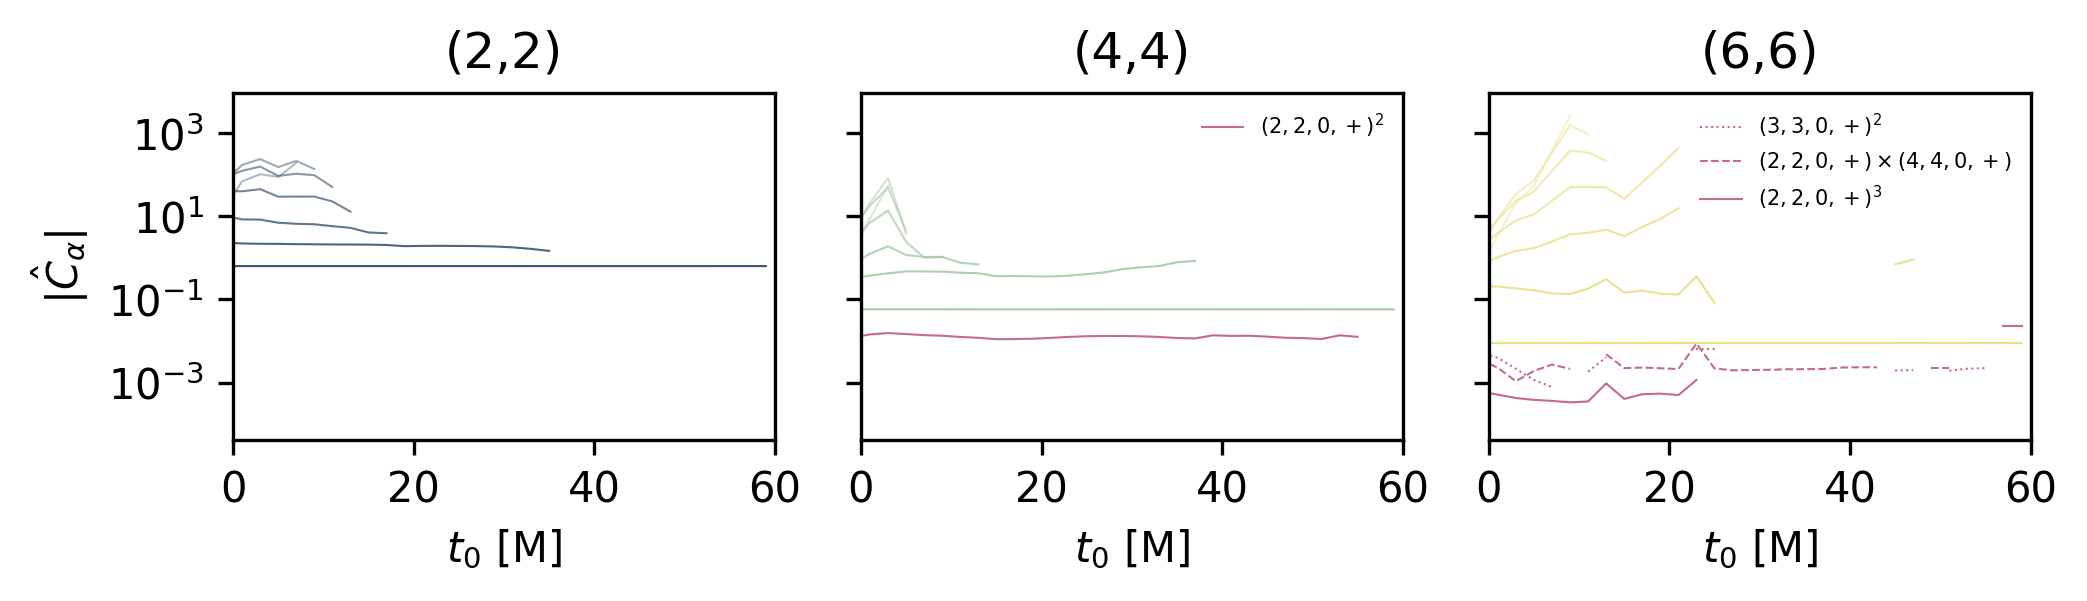

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

groups_to_plot = [(2,2), (4,4), (6,6)]
fig, axes = plt.subplots(1, 3, figsize=(config.fig_width_2, config.fig_height), sharey=True, dpi=300)

for ax, (l, m) in zip(axes, groups_to_plot):
    possible_modes_for_plot = [mode for mode in unique_modes if (len(mode) == 4 or len(mode) == 2) and mode[0] == l and mode[1] == m] + \
                             [mode for mode in unique_modes if len(mode) == 8 and (mode[0] + mode[4] == l) and (mode[1] + mode[5] == m)] + \
                             [mode for mode in unique_modes if len(mode) == 12 and (mode[0] + mode[4] + mode[8] == l) and (mode[1] + mode[5] + mode[9] == m)]

    if not possible_modes_for_plot:
        continue

    base_color = l_to_color.get(l, "#888888")

    for mode in possible_modes_for_plot:
        label = nonlinear_modes[mode] if mode in nonlinear_modes else ''
        if len(mode) == 4:
            _, em, n, p = mode
            if np.sign(em) != np.sign(p):
                continue
            alpha = 1-0.1*n
            color = base_color 
            ls = '-'
            lw = 0.5
        elif len(mode) == 2:
            p = 1
            n = 0
            alpha = 1.0 
            color = special_color_1
            ls = nonlinear_linestyle.get(mode, '-')
            lw = 0.5
        elif len(mode) == 8 or len(mode) == 12:
            p = 1
            n = 0
            alpha = 1.0 
            color = special_color_1
            ls = nonlinear_linestyle.get(mode, '-')
            lw = 0.5

        runs = masks(mode, t0_vals, full_modes_list)
        for run in runs:
            temp_t0_vals = t0_vals[run]
            amps = np.zeros_like(temp_t0_vals)
            lowers = np.zeros_like(temp_t0_vals)
            uppers = np.zeros_like(temp_t0_vals)
            for i, t0 in enumerate(temp_t0_vals):
                tidx = t0_vals.tolist().index(t0)
                idx = full_modes_list[tidx].index(mode)
                amps[i] = np.median(fits[tidx].fit["sample_amplitudes"][:, idx])
                lowers[i] = np.percentile(fits[tidx].fit["sample_amplitudes"][:, idx], 1)
                uppers[i] = np.percentile(fits[tidx].fit["sample_amplitudes"][:, idx], 99)
            if len(temp_t0_vals) > 1:
                ax.plot(temp_t0_vals - 1, amps,
                        color=color, alpha=alpha, lw=lw,
                        label=label if run[0] == runs[0][0] else "",
                        ls=ls)
                ax.fill_between(temp_t0_vals - 1, lowers, uppers, color=color, alpha=0.15, linewidth=0)
            else:
                # Plot the same amplitude value at two consecutive time steps for visibility
                ax.plot([temp_t0_vals[0] - 1, temp_t0_vals[0] + 1], [amps[0], amps[0]],
                        color=color, alpha=alpha, lw=lw,
                        label=label if run[0] == runs[0][0] else "",
                        ls=ls)

    ax.set_xlim([t0_vals[0], t0_vals[-1]])
    ax.set_xlabel(r"$t_0$ [M]")
    ax.set_title(f"({l},{m})")
    ax.set_yscale('log')
    ax.legend(loc='upper right', frameon=False, fontsize=5)

axes[0].set_ylabel(r"$|\hat{C}_{\alpha}|$")
plt.subplots_adjust(wspace=0.05) 
plt.tight_layout()
plt.show()

Plotting mode=(2, 2, 4, 1)
Plotting mode=(2, 2, 0, 1)
Plotting mode=(2, 2, 2, 1)
Plotting mode=(2, 2, 6, 1)
Plotting mode=(2, 2, 5, 1)
Plotting mode=(2, 2, 1, 1)
Plotting mode=(2, 2, 3, 1)


/tmp/ipykernel_2239789/3015350425.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', frameon=False, fontsize=8)


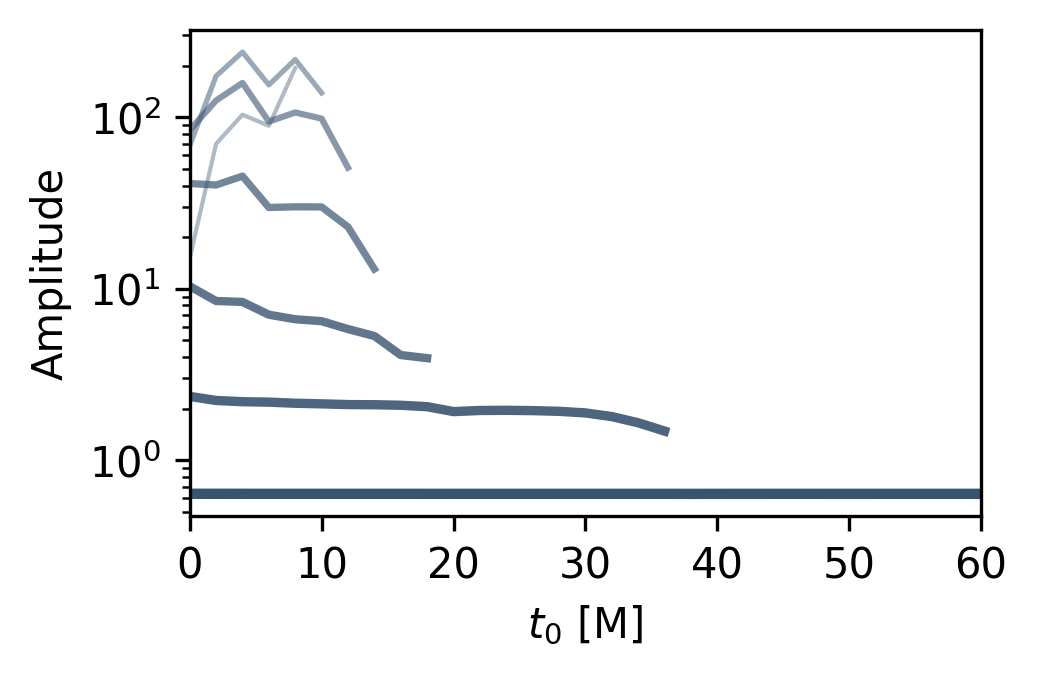

Plotting mode=(3, 2, 3, 1)
Plotting mode=(3, 2, 6, 1)
Plotting mode=(3, 2, 2, 1)
Plotting mode=(3, 2, 4, 1)
Plotting mode=(3, 2, 0, 1)
Plotting mode=(3, 2, 1, 1)
Plotting mode=(3, 2, 5, 1)


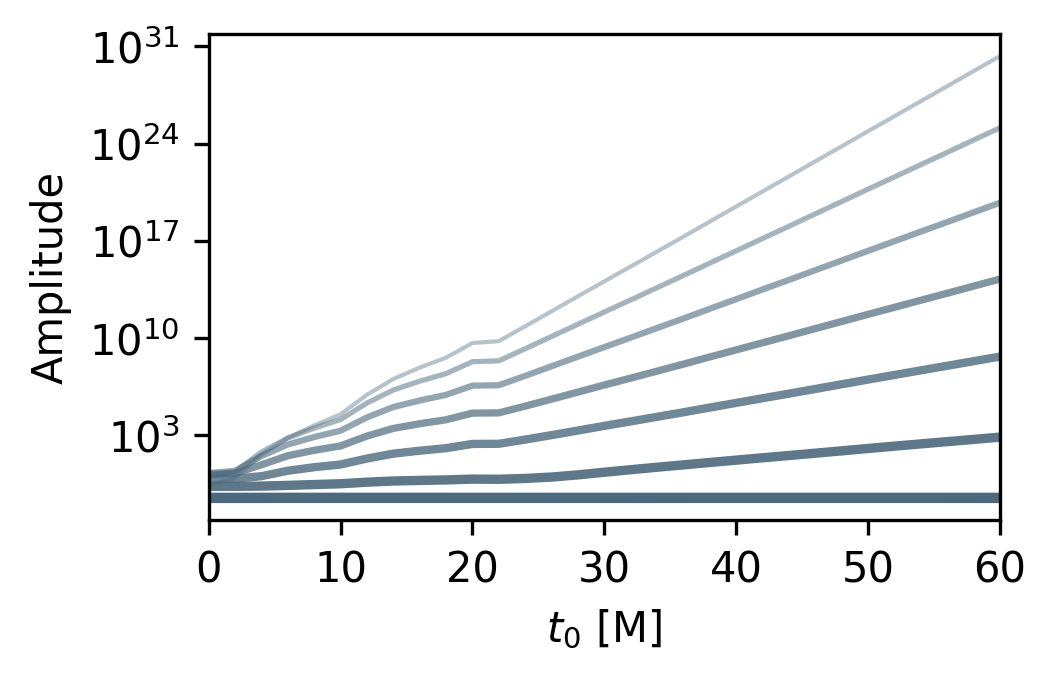

Plotting mode=(3, 3, 2, 1)
Plotting mode=(3, 3, 5, 1)
Plotting mode=(3, 3, 0, 1)
Plotting mode=(3, 3, 4, 1)
Plotting mode=(3, 3, 1, 1)
Plotting mode=(3, 3, 3, 1)
Plotting mode=(3, 3, 6, 1)


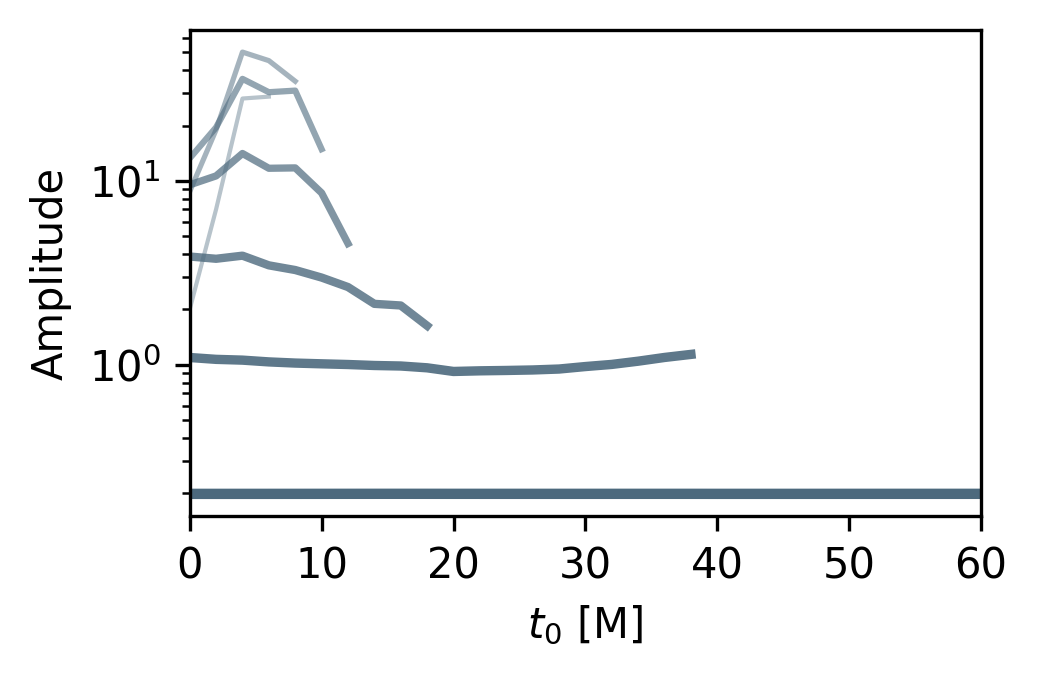

Plotting mode=(4, 3, 3, 1)
Plotting mode=(4, 3, 1, 1)
Plotting mode=(4, 3, 5, 1)
Plotting mode=(4, 3, 4, 1)
Plotting mode=(4, 3, 6, 1)
Plotting mode=(4, 3, 0, 1)
Plotting mode=(4, 3, 2, 1)


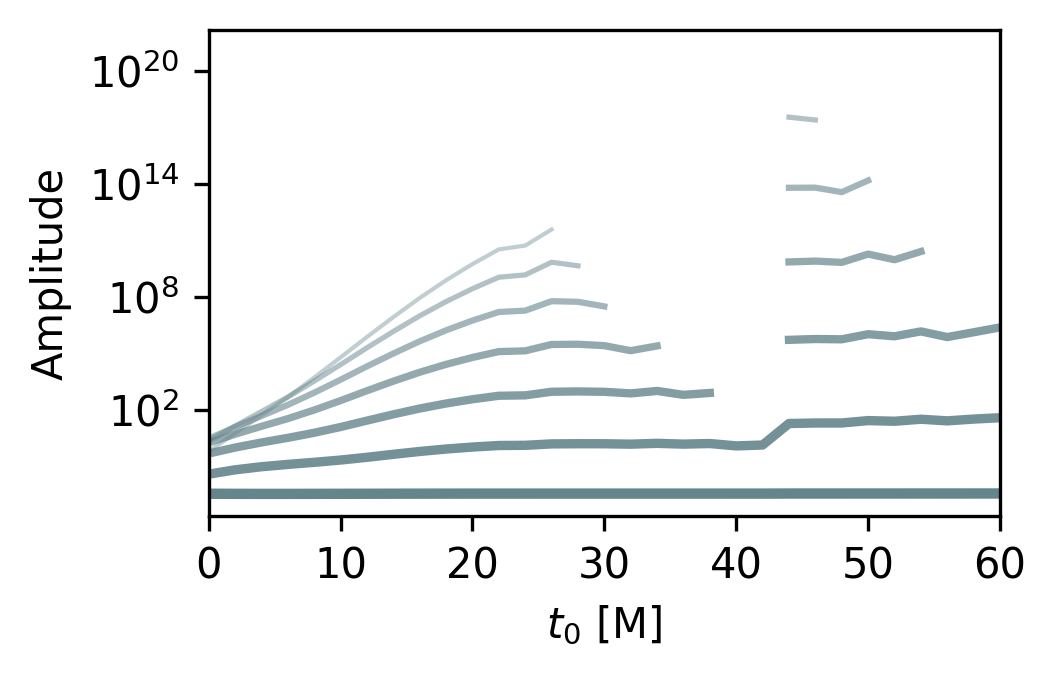

Plotting mode=(4, 4, 0, 1)
Plotting mode=(4, 4, 1, 1)
Plotting mode=(4, 4, 5, 1)
Plotting mode=(4, 4, 3, 1)
Plotting mode=(4, 4, 6, 1)
Plotting mode=(4, 4, 2, 1)
Plotting mode=(4, 4, 4, 1)
Plotting mode=(2, 2, 0, 1, 2, 2, 0, 1)


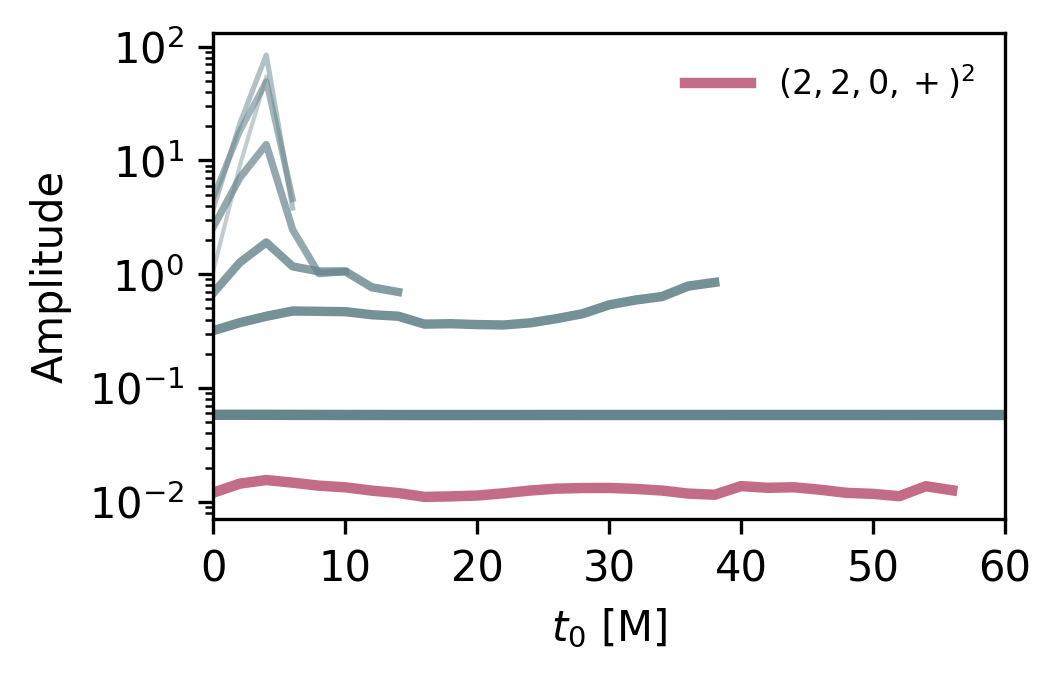

Plotting mode=(5, 4, 0, 1)
Plotting mode=(5, 4, 4, 1)
Plotting mode=(5, 4, 6, 1)
Plotting mode=(5, 4, 2, 1)
Plotting mode=(5, 4, 3, 1)
Plotting mode=(5, 4, 5, 1)
Plotting mode=(5, 4, 1, 1)


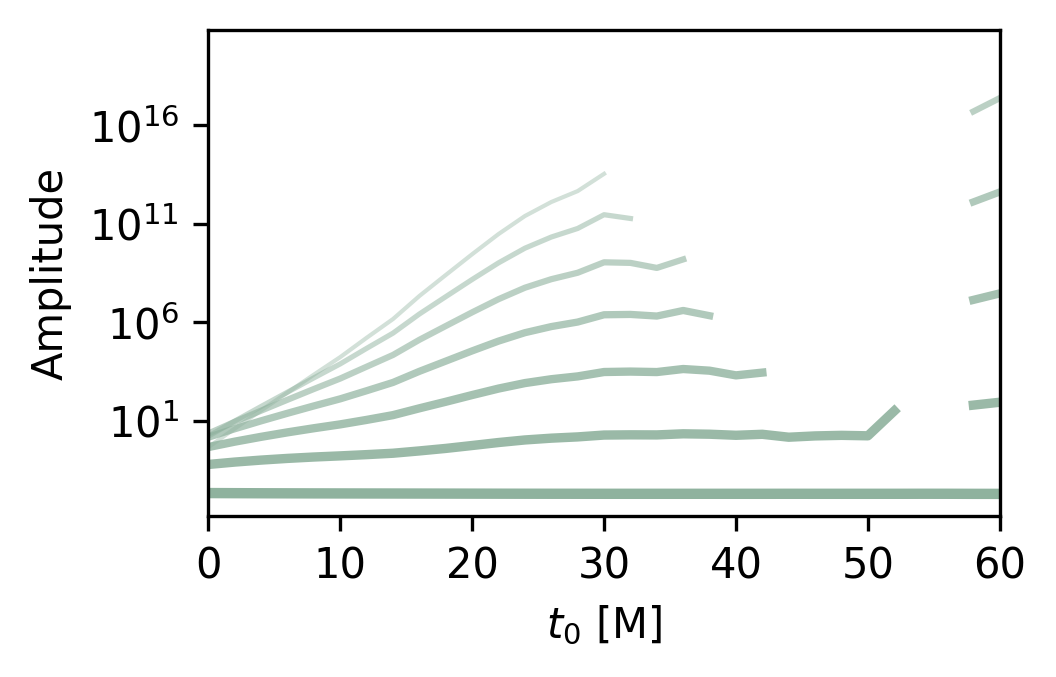

Plotting mode=(5, 5, 0, 1)
Plotting mode=(5, 5, 6, 1)
Plotting mode=(5, 5, 2, 1)
Plotting mode=(5, 5, 4, 1)
Plotting mode=(5, 5, 5, 1)
Plotting mode=(5, 5, 1, 1)
Plotting mode=(5, 5, 3, 1)
Plotting mode=(2, 2, 0, 1, 3, 3, 0, 1)


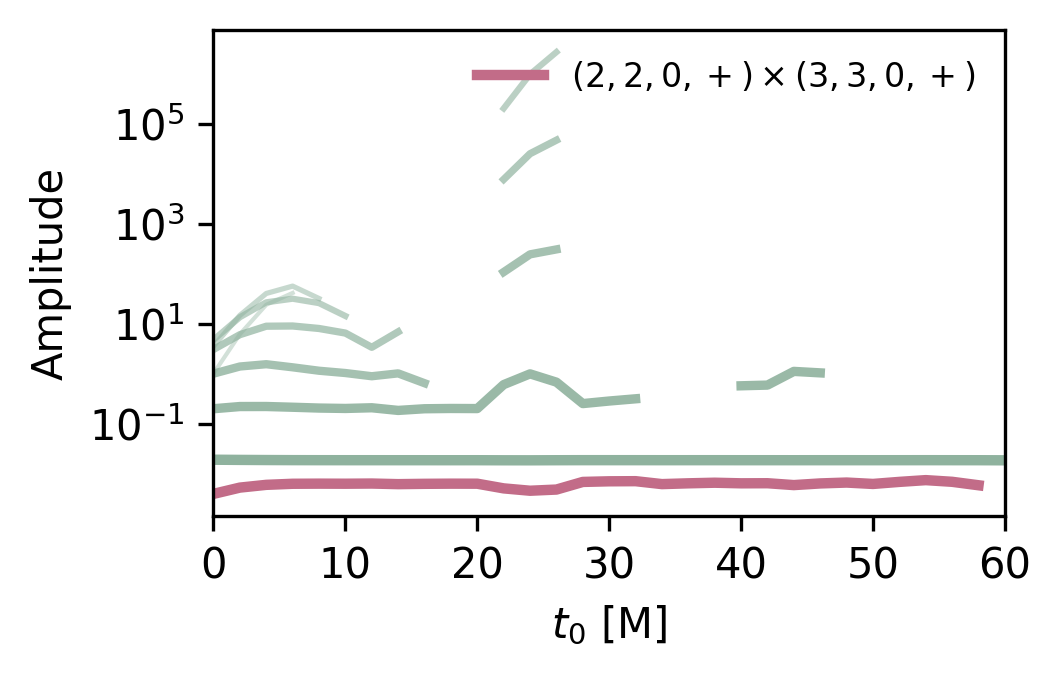

Plotting mode=(6, 5, 1, 1)
Plotting mode=(6, 5, 5, 1)
Plotting mode=(6, 5, 3, 1)
Plotting mode=(6, 5, 4, 1)
Plotting mode=(6, 5, 6, 1)
Plotting mode=(6, 5, 0, 1)
Plotting mode=(6, 5, 2, 1)


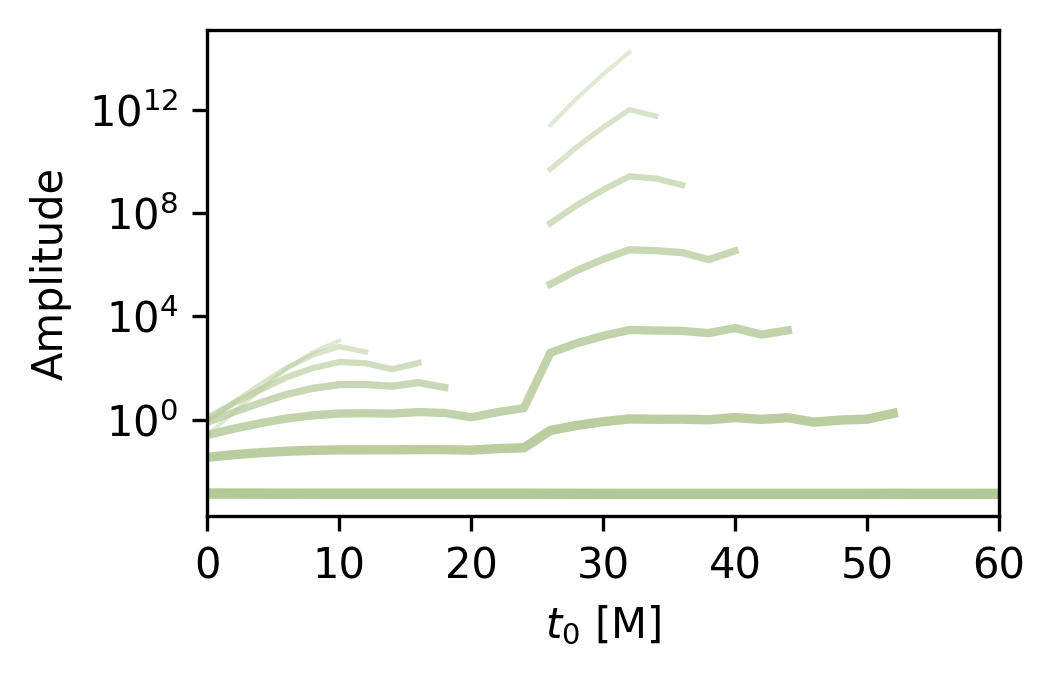

Plotting mode=(6, 6, 2, 1)
Plotting mode=(6, 6, 3, 1)
Plotting mode=(6, 6, 5, 1)
Plotting mode=(6, 6, 1, 1)
Plotting mode=(6, 6, 4, 1)
Plotting mode=(6, 6, 0, 1)
Plotting mode=(6, 6, 6, 1)
Plotting mode=(3, 3, 0, 1, 3, 3, 0, 1)
Plotting mode=(2, 2, 0, 1, 4, 4, 0, 1)


NameError: name 'special_color_2' is not defined

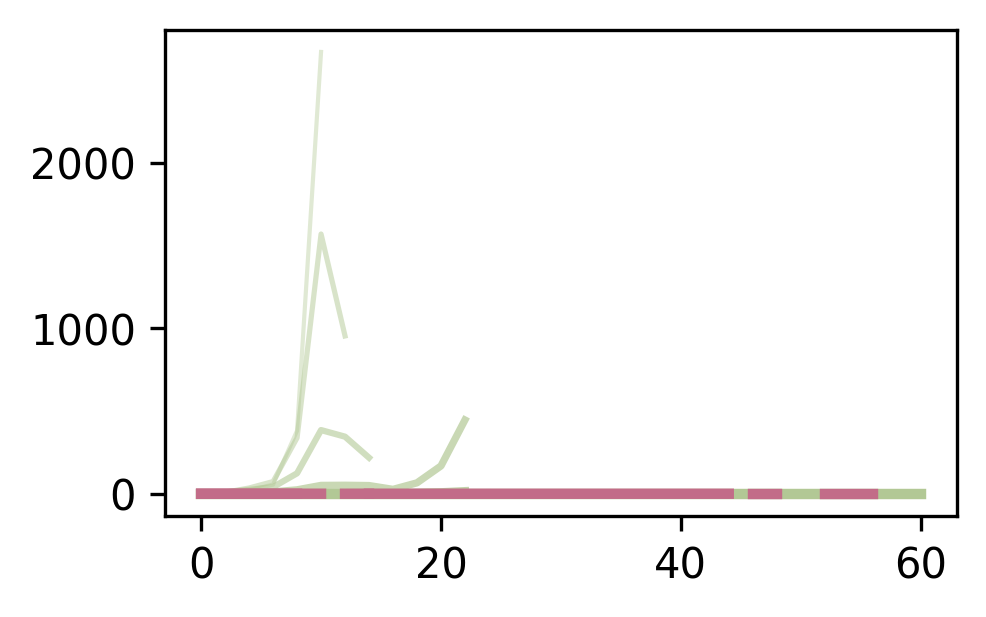

In [9]:
for l in range(2, l_max+1):
    for m in range(-l, l+1):
        possible_modes_for_plot = [mode for mode in unique_modes if (len(mode) == 4 or len(mode) == 2) and mode[0] == l and mode[1] == m] + \
                    [mode for mode in unique_modes if len(mode) == 8 and (mode[0] + mode[4] == l) and (mode[1] + mode[5] == m)] + \
                    [mode for mode in unique_modes if len(mode) == 12 and (mode[0] + mode[4] + mode[8] == l) and (mode[1] + mode[5] + mode[9] == m)]
        
        if possible_modes_for_plot == []:
            continue

        colors = LinearSegmentedColormap.from_list("custom_colormap", config.colors)(np.linspace(0, 1, l_max+1))

        fig, ax = plt.subplots(figsize=(config.fig_width, config.fig_height), dpi=300)

        for mode in possible_modes_for_plot:
            label=f'{mode}'
            if len(mode) == 4:
                _, em, n, p = mode
                if np.sign(em) != np.sign(p):
                    continue
                color = colors[l-2]
            elif len(mode) == 2:
                p = 1
                n = 0
                color = special_color_3
            elif len(mode) == 8:
                p = 1
                n = 0
                color = special_color_1
            elif len(mode) == 12:
                p = 1
                n = 0 
                color = special_color_2
            print(f'Plotting {mode=}') 
            runs = masks(mode, t0_vals, full_modes_list)
            label = nonlinear_modes[mode] if mode in nonlinear_modes else ""
            for j, run in enumerate(runs):
                temp_t0_vals = t0_vals[run]
                amps = np.zeros_like(temp_t0_vals)
                for i, t0 in enumerate(temp_t0_vals):
                    tidx = t0_vals.tolist().index(t0)
                    idx = full_modes_list[tidx].index(mode)
                    amps[i] = np.median(fits[tidx].fit["sample_amplitudes"][:, idx]) 
                ax.plot(temp_t0_vals, amps,
                        color=color, alpha=1-0.1*n, lw=2.5-0.25*n,
                        label=label,
                        ls = '-'
                        )

        ax.set_xlim([t0_vals[0], t0_vals[-1]])
        ax.set_xlabel(r"$t_0$ [M]")
        ax.set_ylabel("Amplitude")
        ax.set_yscale('log')

        ax.legend(loc='upper right', frameon=False, fontsize=8)

        plt.show() 
        plt.close()